# Visualization of Cloud-Optimized Earth Observation Data using Lonboard

This tutorial illustrates processing and visualizing EO data - Cloud-Optimized GeoTIFFs (COGs) and Cloud-Optimized Point Clouds (COPCs) using [Lonboard](https://developmentseed.org/lonboard/latest/). Lonboard is capable of visualizing big raster and vector datasets including widely used image formats such as COGs and LiDAR data files such as COPCs, LAS file formats.

In this tutorial, Airborne LiDAR Scanning (ALS) based point cloud for Panama, BCI is used for visualization along with the Above-ground Biomass (AGB) Estimate and [Meta's Canopy Height Model (CHM)](https://www.sciencedirect.com/science/article/pii/S003442572300439X?via%3Dihub) products. We created COGs for these products and use [TiTiler](https://developmentseed.org/titiler/) for dynamically serving tiles from the generated COGs for visualization. The point cloud represents normalized canopy cover heights generated from the raw point cloud data.

Additional Resources:
1. [Lonboard](https://developmentseed.org/lonboard/latest/)
2. [TiTiler](https://developmentseed.org/titiler/)
3. [Converting LiDAR LAS Files to Cloud-Optimized Point Clouds (COPCs)](https://guide.cloudnativegeo.org/copc/lidar-las-to-copc.html)
4. [Introduction to Cloud-Optimized GeoTIFFs](https://guide.cloudnativegeo.org/cloud-optimized-geotiffs/intro.html)
5. [PDAL](https://pdal.io/en/2.6.0/about.html#what-is-pdal)


### Importing Packages

We import the required packages for this tutorial.  

In [1]:
import geopandas as gpd
from lonboard import viz
import pdal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lonboard import Map, BitmapLayer, BitmapTileLayer, PointCloudLayer, PolygonLayer
from lonboard.colormap import apply_continuous_cmap
import httpx
import json
from palettable.colorbrewer.sequential import YlGnBu_7, Greens_3
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import Normalize

(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory

Next, we define the path to the ALS LiDAR file in COPC format to be visualized.

In [28]:
out_file = "data/ALS_ground_copc/outputs/norm_aoi/norm_chunk.copc.laz"

### Reading the COPC file

We read the COPC file using the PDAL python package. Also, we sample the number of points by a factor of 50, thus reducing the number of points for visualization to save memory. PDAL processes point cloud data by executing pipelines comprising of various operations (separated by `|` below). For more details, the readers are recommended to follow [Converting LiDAR LAS Files to Cloud-Optimized Point Clouds (COPCs)](https://guide.cloudnativegeo.org/copc/lidar-las-to-copc.html).

In [30]:
pipeline = (pdal.Reader.copc(filename=out_file) | pdal.Filter.decimation(step=50) | pdal.Filter.stats())
pipeline.execute()

1425310

### Getting the Data Values

The data values from an executed pipeline are retrieved by calling the `arrays` method.

In [31]:
# Getting array values
arr_values = pipeline.arrays

### Creating Geo-dataframe

Now, we will create a data frame followed by a Geo-dataframe based on the data values. Lonboard requires the vector data as Geo-dataframe for visualization.

In [32]:
df = pd.DataFrame(arr_values[0])

In [33]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y, z=df.Z), crs="32617")

Also, Lonboard requires the Geo-dataframe to have its Spatial Reference System (SRS) as World Geodetic System 1984 (WGS 84). So, we re-project the geo-dataframe to `EPSG 4326`, which is the unique reference code for WGS 84.

In [34]:
gdf_proj = gdf.to_crs(4326)
gdf_proj.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,ScanChannel,ClassFlags,TargetThick,DevRatio,Zref,geometry
0,626687.45,1012332.20,7.43,6,3,3,0,0,1,-20.268000,1,13,3.691526e+08,0,0,0.000,1.2,155.32,POINT Z (-79.84697 9.15627 7.43000)
1,626679.39,1012333.98,0.16,12,4,4,0,0,2,-2.322000,1,14,3.691529e+08,0,0,0.120,0.8,149.12,POINT Z (-79.84704 9.15629 0.16000)
2,626682.74,1012344.07,1.74,18,3,3,0,0,1,24.612000,1,15,3.691531e+08,0,0,0.120,0.9,151.55,POINT Z (-79.84701 9.15638 1.74000)
3,626718.76,1012332.77,22.91,45,1,3,0,0,1,-19.230000,3,13,3.691526e+08,0,0,0.080,0.9,169.69,POINT Z (-79.84668 9.15628 22.91000)
4,626721.90,1012345.96,14.93,71,1,1,0,0,1,-17.724001,1,13,3.691526e+08,0,0,0.152,1.6,162.03,POINT Z (-79.84666 9.15640 14.93000)


In order to save memory, we delete the unrequired data frames. Also, we drop the columns which are not relevant for the visulization.

In [35]:
# Deleting not required dataframes
del(df)
del(gdf)

In [36]:
#Dropping not required columns
gdf_proj = gdf_proj.drop(['ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime', 'Intensity', 'Classification', 'ScanChannel', 'ClassFlags', 'TargetThick', 'DevRatio', 'Zref'], axis=1)

### Define a Point Cloud Layer

We define a Point Cloud Layer based on the geo-dataframe.

In [37]:
point_layer = PointCloudLayer.from_geopandas(gdf_proj, point_size=2)

### Styling Point Cloud Layer

Here, we normalize the elevation values and create a color map for visualizing the point cloud layer. 

In [38]:
normalizer = Normalize(1, gdf_proj["Z"].max(), clip=True)
normalized_heights = normalizer(gdf_proj["Z"])

In [39]:
point_layer.get_color = apply_continuous_cmap(normalized_heights, Greens_3, alpha=0.6)

### Reading AGB Product Layer

For visualizing COGs, we use `BitmapTileLayer` which renders tiles dynamically generated by TiTiler.

In [40]:
titiler_endpoint = "https://titiler.maap-project.org"

In [41]:
#AGB product stored locally in MAAP workspace
agb_product_url = "s3://maap-ops-workspace/shared/omshinde23/agbd.tif"

In [42]:
agb_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/omshinde23/agbd.tif&bidx=5&rescale=0,600&colormap_name=viridis"

In [43]:
r_agb = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": agb_product_url,
    }
).json()

bounds_agb = r_agb["bounds"]
print(bounds_agb)

[-79.87926821173158, 9.121956517182756, -79.81171917965493, 9.186829702218509]


In [44]:
agb_product_layer = BitmapTileLayer(
    data=agb_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=3,
    max_zoom=18,
    extent=bounds_agb
)

### Reading BCI Trails 2022 layer

In addition to the point cloud layer and the AGB product layer, we add the BCI Trails 2022 layer downloaded locally for the visualization. 

Source: [Barro Colorado Trail systems update 2022](https://stridata-si.opendata.arcgis.com/datasets/SI::bci-trails-2022/explore?location=0.000302%2C-79.844095%2C0.00)

In [45]:
url = "./BCI_Trails_2022_-8446373283477327423.zip"
gdf_trail = gpd.read_file(url, engine="pyogrio")
gdf_trail.head()

,NAME,FullName,TYPE,LABEL,GlobalID,geometry
0,Harvard,Harvard University,Official Trail,Harvard,57c9f376-c503-4cc7-a726-7dbfb94d7eab,"LINESTRING (628307.169 1012001.681, 628325.366..."
1,Chapman,Frank M. Chapman,Official Trail,Chapman,cc890b54-0cef-478d-a430-8b91c3417392,"LINESTRING (628324.057 1012070.975, 628336.246..."
2,T. Barbour,Thomas Barbour,Official Trail,T. Barbour,de8e8f6c-ec5f-40ae-9b80-a07daea0fd23,"LINESTRING (627565.566 1012934.428, 627572.856..."
3,Hood,J. Douglas Hood,Official Trail,Hood,e7ba1fb5-03ac-4e5c-8d6a-c9d31955b1cc,"LINESTRING (628602.380 1012605.884, 628605.737..."
4,Van Tyne,Josselyn Van Tyne,Official Trail,Van Tyne,8a5646f3-9b31-4ee7-bbce-f75ffff47244,"LINESTRING (628100.448 1012528.073, 628113.856..."


In [49]:
#Converting the geometry to EPSG:4326
gdf_trail_proj = gdf_trail.to_crs(4326)
gdf_trail_proj.head()

,NAME,FullName,TYPE,LABEL,GlobalID,geometry
0,Harvard,Harvard University,Official Trail,Harvard,57c9f376-c503-4cc7-a726-7dbfb94d7eab,"LINESTRING (-79.83224 9.15324, -79.83207 9.153..."
1,Chapman,Frank M. Chapman,Official Trail,Chapman,cc890b54-0cef-478d-a430-8b91c3417392,"LINESTRING (-79.83208 9.15386, -79.83197 9.153..."
2,T. Barbour,Thomas Barbour,Official Trail,T. Barbour,de8e8f6c-ec5f-40ae-9b80-a07daea0fd23,"LINESTRING (-79.83896 9.16169, -79.83890 9.161..."
3,Hood,J. Douglas Hood,Official Trail,Hood,e7ba1fb5-03ac-4e5c-8d6a-c9d31955b1cc,"LINESTRING (-79.82954 9.15869, -79.82951 9.158..."
4,Van Tyne,Josselyn Van Tyne,Official Trail,Van Tyne,8a5646f3-9b31-4ee7-bbce-f75ffff47244,"LINESTRING (-79.83411 9.15800, -79.83398 9.157..."


### Creating Map Visualization for AGB Layer

Here, we visualize the AGB layer and point cloud layer in a single `Map` widget. The readers are recommended to use `Ctrl+Click+Drag` to change the viewing angle. Also, hover over the BCI trails to get more information about a particular trail.

In [50]:
#Function for generating colormap for AGB and CHM layer legend

def plot_colormap(gradient_max, title, cmap):
    
    gradient = np.linspace(0, 10, gradient_max)
    gradient = np.vstack((gradient, gradient))
    
    # Create figure and adjust figure height to number of colormaps
    nrows = 1
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)
    
    axs.get_yaxis().set_visible(False)

    axs.set_title(title, fontsize=14)
    axs.imshow(gradient, aspect='auto', cmap=cmap)

In [57]:
from lonboard import Map, PathLayer
trail_layer = PathLayer.from_geopandas(gdf_trail_proj, width_min_pixels=2.5)
trail_layer.auto_highlight = True

In [58]:
m = Map([agb_product_layer, trail_layer, point_layer])
m

Map(layers=[BitmapTileLayer(data='https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-wor…

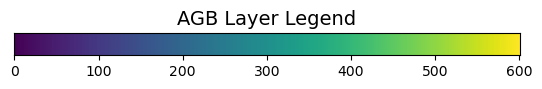

In [59]:
# AGB values range 0-600, so gradient_max = 601
plot_colormap(601, "AGB Layer Legend",'viridis')

### Reading META CHM Layer

Now, we visualize the META CHM layer with the point cloud layer.

In [60]:
chm_product_url = "s3://maap-ops-workspace/shared/omshinde23/meta_chm_new.tif"

In [61]:
chm_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/omshinde23/meta_chm_new.tif&rescale=0,60&colormap_name=viridis"

In [62]:
r_chm = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": chm_product_url,
    }
).json()

bounds_chm = r_chm["bounds"]
print(bounds_chm)

[-79.87929430332252, 9.122007215999078, -79.81190140986412, 9.187029513446365]


In [63]:
chm_product_layer = BitmapTileLayer(
    data=chm_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=3,
    max_zoom=18,
    extent=bounds_chm
)

In [66]:
m1 = Map([chm_product_layer, trail_layer, point_layer])
m1

Map(layers=[BitmapTileLayer(data='https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-wor…

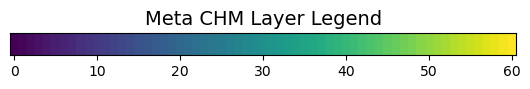

In [68]:
plot_colormap(61, "Meta CHM Layer Legend",'viridis')